In [2]:
# Make sure it's running on DETR conda env
import sys
print(sys.executable)

/home/marcelo/anaconda3/envs/DETR/bin/python3.7


### Preliminaries

In [3]:
import math
from pathlib import Path
import random

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

#from models.detr import DETR
#from models.transformer import Transformer

In [4]:
# COCO classes
CLASSES = [
    'nodule'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741]]

In [5]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    #T.Resize(1333),
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax -ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.5f}'
        #text = f'{CLASSES[cl]}: {p[cl]}'
        ax.text(xmin, ymin-6, text, fontsize=14,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [7]:
def detect(im, model, transform, confidence=0.7):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1333 and img.shape[-1] <= 1333, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > confidence

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

### Detection

In [9]:
num_classes = 1
num_queries = 10

model = torch.hub.load('facebookresearch/detr', 'detr_resnet50_dc5', pretrained=True)
#model = DETRdemo(num_classes=1)

model.class_embed.out_features = num_classes + 1
model.class_embed.weight = nn.Parameter(torch.rand(num_classes+1, 256))
model.class_embed.bias = nn.Parameter(torch.rand(num_classes+1))
model.query_embed = nn.Embedding(num_queries, model.class_embed.in_features)
model.num_queries = num_queries

#path = "output_seg/checkpoint.pth"
path = "output/checkpoint.pth"

checkpoint = torch.load(path)
print(len(checkpoint["model"].keys()))


model.load_state_dict(checkpoint['model'], strict=False)
model.eval();

Using cache found in /home/marcelo/.cache/torch/hub/facebookresearch_detr_main


458


In [ ]:
model.query_embed

In [ ]:
#imgs_path = Path('../dataset/luna_images_seg_test/')
imgs_path = Path('../dataset/luna_images_test/')
imgs_list = list(Path(imgs_path).glob('*'))

In [ ]:
index = random.randint(0, len(imgs_list))
im = Image.open(imgs_list[index])

print(imgs_list[index].name)


scores, boxes = detect(im, model, transform, 0.5)


plot_results(im, scores, boxes)

In [70]:
num_classes = 1
num_queries = 10

model = torch.hub.load('facebookresearch/detr',
                       #'detr_resnet50_dc5',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes
                       #dilation=True  # to test
                      )

#checkpoint = torch.load('output_seg/checkpoint.pth', map_location='cpu')
checkpoint = torch.load('output/checkpoint.pth', map_location='cpu')

model.query_embed = nn.Embedding(num_queries, model.class_embed.in_features)
model.num_queries = num_queries
#del checkpoint["model"]["class_embed.weight"]
#del checkpoint["model"]["class_embed.bias"]

model.load_state_dict(checkpoint['model'], strict=False)

model.eval();

Using cache found in /home/marcelo/.cache/torch/hub/facebookresearch_detr_main


In [71]:
model.query_embed

Embedding(10, 256)

In [69]:
#imgs_path = Path('../dataset/dataset2_seg_test/')
imgs_path = Path('../dataset/dataset2_test/')
imgs_list = list(Path(imgs_path).glob('*'))

Index: 17
File name: img_1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391_153.jpg


/home/marcelo/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


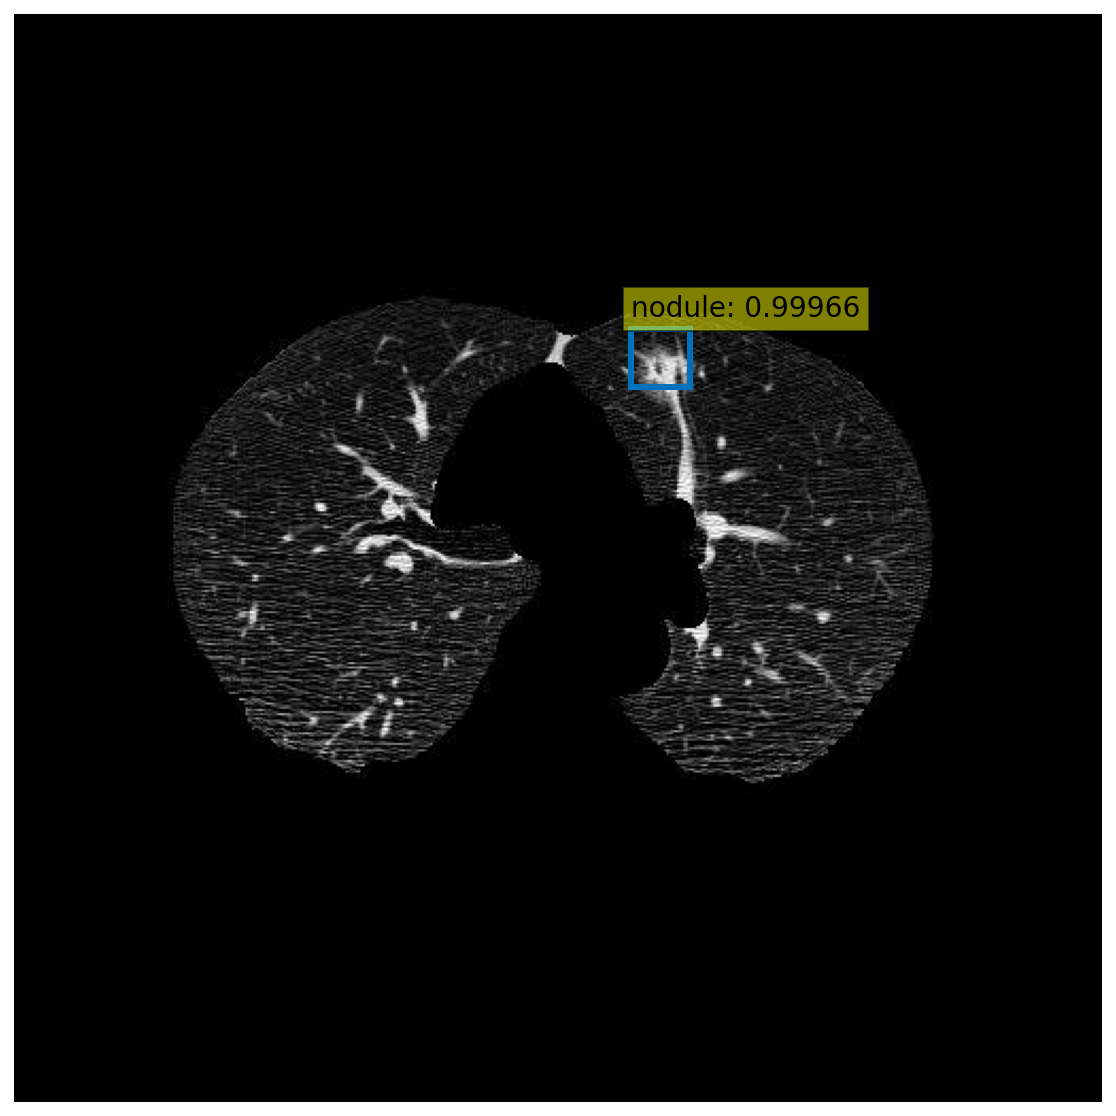

In [13]:
index = random.randint(0, len(imgs_list))
#index = 236
im = Image.open(imgs_list[index])
#im = im.resize([800,800])
im_name = imgs_list[index].name


print(f"Index: {index}\nFile name: {im_name}")


scores, boxes = detect(im, model, transform, 0.7)


plot_results(im, scores, boxes)

In [14]:
# Functions to plot the groud truth


# For object detection annotations in COCO, the format is "bbox" : [x,y,width,height]
# Where:
# x, y: the upper-left coordinates of the bounding box
# width, height: the dimensions of your bounding box

import json

def get_gt_boxes(im_name, json_path):
    # Load the JSON annotations file
    f = open(json_path)
    anns = json.load(f)
    
    # Find the image ID
    for i in anns["images"]:
        if i['file_name'] == im_name:
            coco_id = i['id']
            print(coco_id)
            break
    
    # Find the ground truth bboxes
    gt_bboxes = []
    for i in anns["annotations"]:
        if i['image_id'] == coco_id:
            gt_bboxes.append(i['bbox'])
    
    return gt_bboxes


# boxes in COCO format: xywh
def plot_gt(pil_img, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, w, h), c in zip(boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), w, h,
                                   fill=False, color='red', linewidth=3))
        text = f'nodule'
        ax.text(xmin, ymin-6, text, fontsize=14,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()    

271


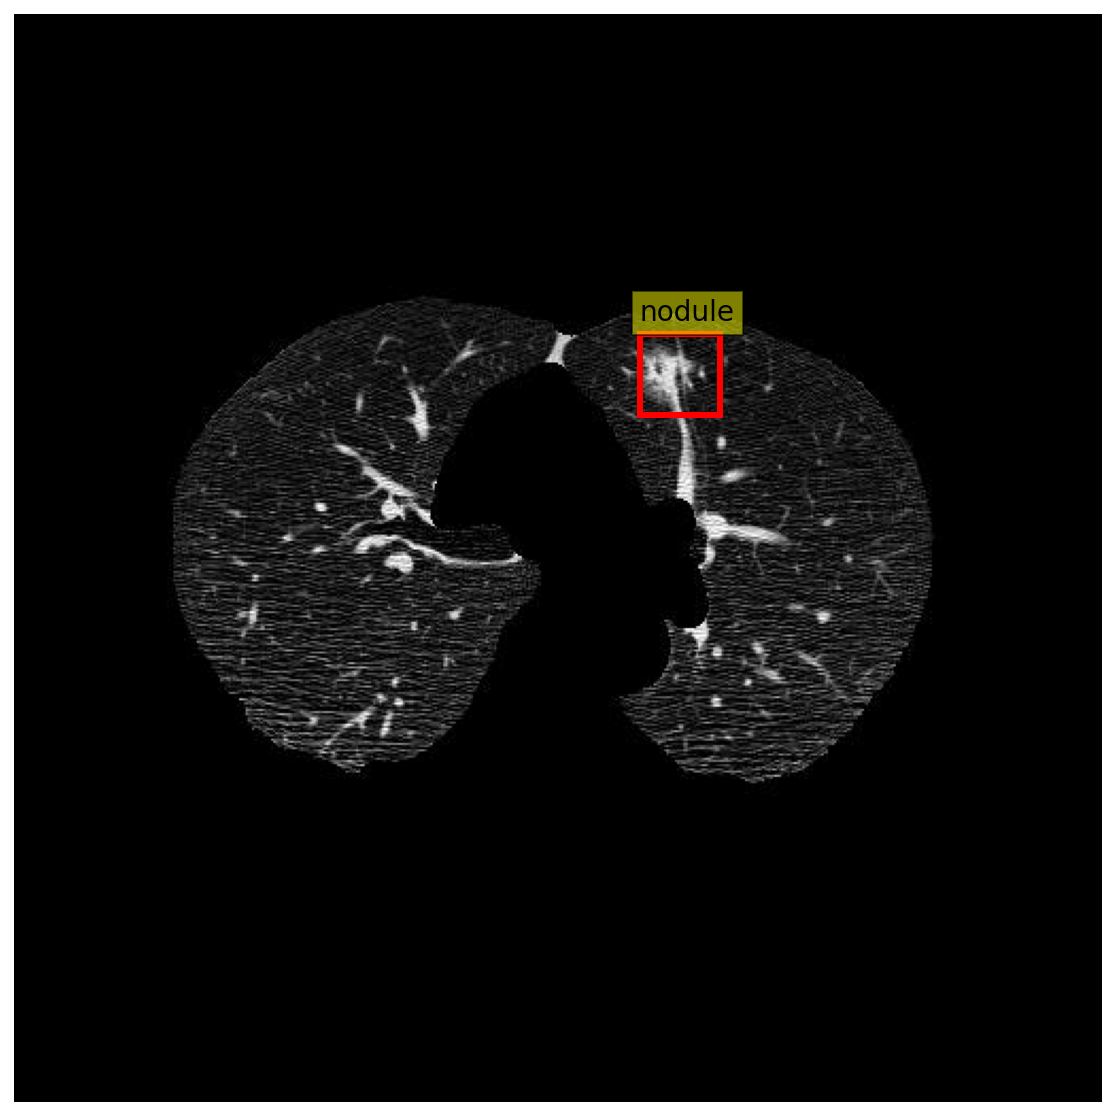

In [15]:
json_path = '../dataset/dataset2_seg_test.json' #"./annotations/instances_train2017.json"

gt_bboxes = get_gt_boxes(im_name, json_path)
plot_gt(im, gt_bboxes)

In [149]:
# Plot both bounding boxes in the same image
# Red: Ground truth
# Blue: Prediction

def plot_results(pil_img, prob, pred_boxes, gt_boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    
    # Add ground truth bboxes
    for (x,y,h,w) in gt_boxes:
        ax.add_patch(plt.Rectangle((x, y), h, w, fill=False, color="red", linewidth=3, alpha=0.6))
        
    # Add prediction bboxes
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, pred_boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color=c, linewidth=3, alpha=0.7))
        
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.5f}'
        ax.text(xmin, ymin-6, text, fontsize=14,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Index: 739
File name: img_1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_77.jpg
38


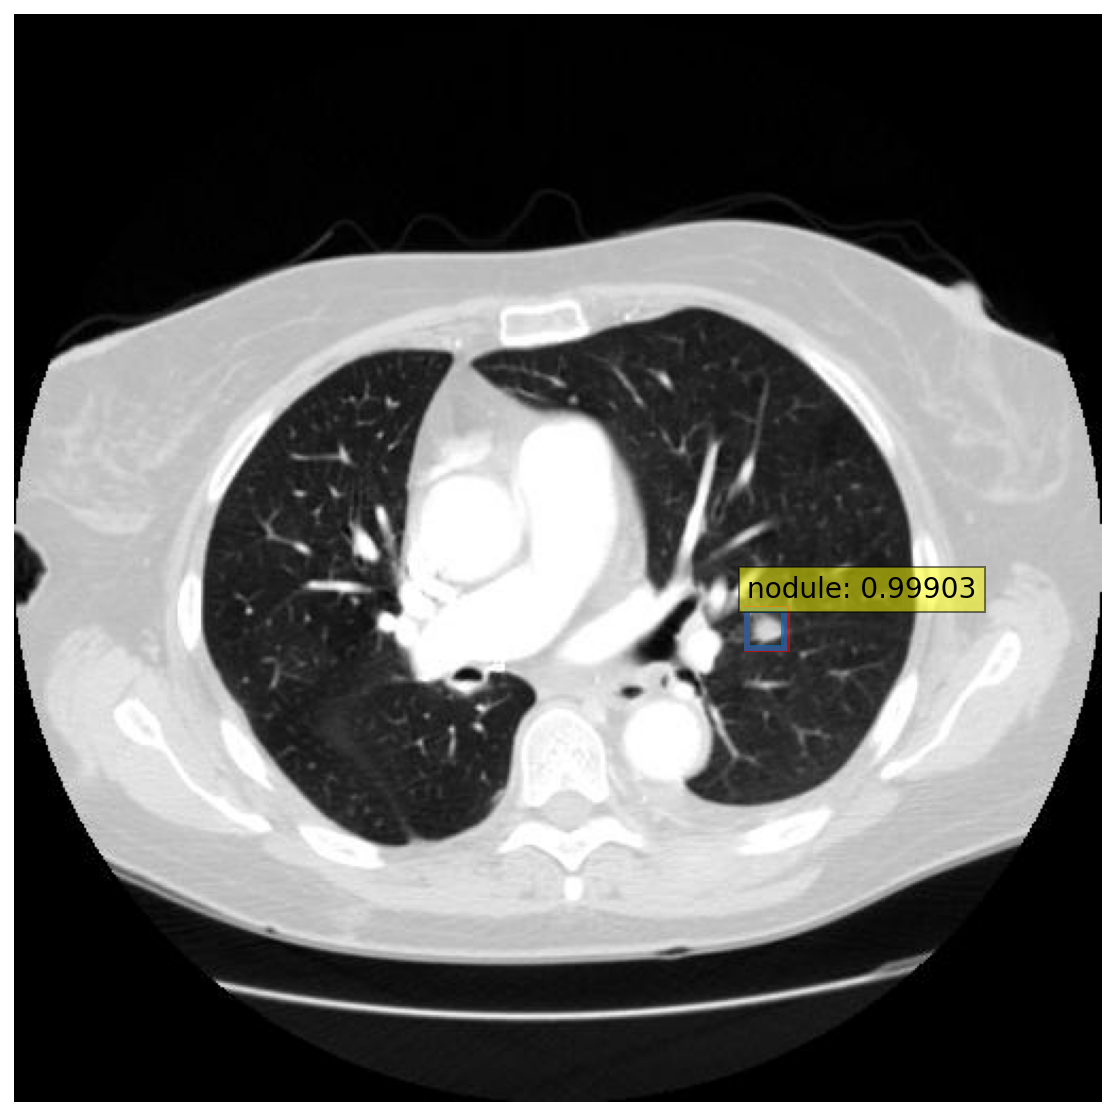

In [152]:
index = random.randint(0, len(imgs_list))
#index = 389
im = Image.open(imgs_list[index])
im_name = imgs_list[index].name

#json_path = '../dataset/dataset2_seg_test.json'
json_path = '../dataset/dataset2_test.json'


print(f"Index: {index}\nFile name: {im_name}")


scores, pred_boxes = detect(im, model, transform, 0.8)
gt_boxes = get_gt_boxes(im_name, json_path)

plot_results(im, scores, pred_boxes, gt_boxes)

In [143]:
for (x,y,h,w) in gt_boxes:
    print(x)

200.0
